# Stack-Overflow Annual Developer Survey Analyis


Within this Analysis I analyze what influences Salary within developer jobs. <br>
The goal is to develop a model that could potentially *help employees estimate their worth* and *employers plan their expense* in a market that is sometimes intransparent in regards to salary.

In [2]:
# Import all packages needed
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeRegressor, plot_tree 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression



In [3]:
# Load survey schema

schema = pd.read_csv('data/survey_results_schema.csv')
schema.head()

,qid,qname,question,force_resp,type,selector
0,QID2,MainBranch,Which of the following options best describes ...,True,MC,SAVR
1,QID127,Age,What is your age?*,True,MC,SAVR
2,QID296,Employment,Which of the following best describes your cur...,True,MC,MAVR
3,QID308,RemoteWork,Which best describes your current work situation?,False,MC,SAVR
4,QID341,Check,Just checking to make sure you are paying atte...,True,MC,SAVR


In [4]:
# Load data

df = pd.read_csv('data/survey_results_public.csv')
df.head()

,ResponseId,MainBranch,Age,Employment,RemoteWork,Check,CodingActivities,EdLevel,LearnCode,LearnCodeOnline,...,JobSatPoints_6,JobSatPoints_7,JobSatPoints_8,JobSatPoints_9,JobSatPoints_10,JobSatPoints_11,SurveyLength,SurveyEase,ConvertedCompYearly,JobSat
0,1,I am a developer by profession,Under 18 years old,"Employed, full-time",Remote,Apples,Hobby,Primary/elementary school,Books / Physical media,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,I am a developer by profession,35-44 years old,"Employed, full-time",Remote,Apples,Hobby;Contribute to open-source projects;Other...,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Colleague;On the job tr...,Technical documentation;Blogs;Books;Written Tu...,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2,3,I am a developer by profession,45-54 years old,"Employed, full-time",Remote,Apples,Hobby;Contribute to open-source projects;Other...,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",Books / Physical media;Colleague;On the job tr...,Technical documentation;Blogs;Books;Written Tu...,...,NaN,NaN,NaN,NaN,NaN,NaN,Appropriate in length,Easy,NaN,NaN
3,4,I am learning to code,18-24 years old,"Student, full-time",NaN,Apples,NaN,Some college/university study without earning ...,"Other online resources (e.g., videos, blogs, f...",Stack Overflow;How-to videos;Interactive tutorial,...,NaN,NaN,NaN,NaN,NaN,NaN,Too long,Easy,NaN,NaN
4,5,I am a developer by profession,18-24 years old,"Student, full-time",NaN,Apples,NaN,"Secondary school (e.g. American high school, G...","Other online resources (e.g., videos, blogs, f...",Technical documentation;Blogs;Written Tutorial...,...,NaN,NaN,NaN,NaN,NaN,NaN,Too short,Easy,NaN,NaN


----------------------------

--------------------

## 1. Exploratory Data Analysis

Check the PDF of the Survey that comes with the data for a detailed understanding of the survey and its questions (i.e. potential features and targets).

#### Check the target = Salary
`ConvertedCompYearly`

In [5]:
# some simple descriptive statistics
print(f'Rows without salary information {df.ConvertedCompYearly.isna().sum()}')
df.ConvertedCompYearly.describe()

Rows without salary information 42002


count    2.343500e+04
mean     8.615529e+04
std      1.867570e+05
min      1.000000e+00
25%      3.271200e+04
50%      6.500000e+04
75%      1.079715e+05
max      1.625660e+07
Name: ConvertedCompYearly, dtype: float64

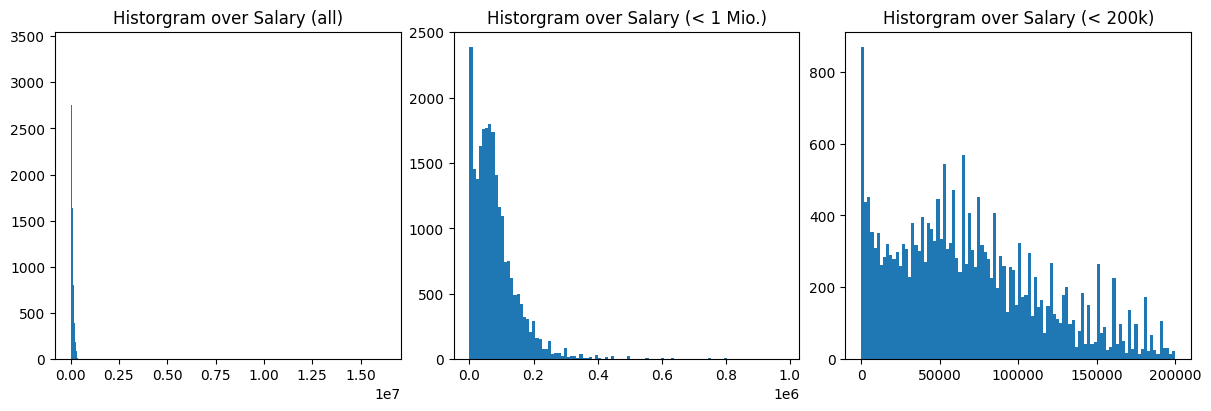

In [6]:
# Check distribution of salary

fig, axs = plt.subplots(1, 3, layout='constrained', figsize=(12, 4))
axs[0].hist(df.ConvertedCompYearly, bins = 1000) 
axs[0].set_title('Historgram over Salary (all)')
axs[1].hist(df.ConvertedCompYearly[df.ConvertedCompYearly < 1000000], bins = 100) 
axs[1].set_title('Historgram over Salary (< 1 Mio.)')
axs[2].hist(df.ConvertedCompYearly[df.ConvertedCompYearly < 200000], bins = 100) 
axs[2].set_title('Historgram over Salary (< 200k)')

plt.show()

*Issues*  to consider:
- Just a little more than 1/3 of the participants gave a salary.
- Salary extremly skewed (potentially influential outliers)
- A lot of participants gave unrealistically small salary (~ 0)


In [7]:
# Exploring Features only on rows with salary!
df2 = df[df.ConvertedCompYearly.notna()].copy()

In [8]:
print(df2[df2.ConvertedCompYearly < 100].ConvertedCompYearly.value_counts())
# salary < 500$ seems unrealistic for a full time job even in low income countries --> exclude

df2 = df2[df2.ConvertedCompYearly > 100]
df2.shape

ConvertedCompYearly
1.0     16
2.0      5
3.0      5
5.0      5
12.0     5
        ..
59.0     1
65.0     1
83.0     1
52.0     1
63.0     1
Name: count, Length: 71, dtype: int64


(23272, 114)

------------------------------------------------------------------------------------------------------------------------------

#### Potential features examination

To keep the model relatively simple, interpretable and usable for prediction features will only include the first two sections of the survey (1. Basic Information & 2 - Education + Work + Career.) <br>
Additionally questions `BuyNewTool`, `BuildvsBuy`, `TechEndorse` will be excluded for two main reasons:
1. No logical reason why they should influence salary
2. And more importantly, not really applicable when trying to predict an appropriate salary

`Currency` will be excluded as Salary in target is converted already and besides conversion, currency mostly represents duplicate information with country.

`LearnCodeOnline` will be excluded as it is clearly secondary information to `LearnCode`.

`TechDoc` will be excluded. This might indirectly represent a devs abilities or style of work but seems like in theory it should not *directly* influence salary.


In [9]:
# make sure to only include those that passed the check of attention in survey
# --> only those who pass can continue the survey so 100% pass in data
df2.Check.describe()

count      23272
unique         1
top       Apples
freq       23272
Name: Check, dtype: object

##### `MainBranch` & `Emplyoment`
Technically we only care about those who work as some sort of dev professionally as we want to determine what influences salary of a dev. For comparibility we stick to full time emplyoment.

In [10]:
# filter to keep only those working as some sort of dev professionally and being employed full time
df3 = df2.copy()[
    (df2['MainBranch'] == "I am a developer by profession") &
    (df2['Employment'].str.contains("Employed, full-time", na=False))
]

df2.shape

(23272, 114)

In [11]:
# preselection of features
df3 = df3[['Age', 'RemoteWork', 'CodingActivities', 'EdLevel', 'LearnCode', 'YearsCode', 'YearsCodePro', 'DevType', 'OrgSize',
       'PurchaseInfluence', 'Country', 'ConvertedCompYearly']]

df3.shape

(18730, 12)

In [12]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18730 entries, 72 to 41187
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  18730 non-null  object 
 1   RemoteWork           18728 non-null  object 
 2   CodingActivities     18727 non-null  object 
 3   EdLevel              18730 non-null  object 
 4   LearnCode            18702 non-null  object 
 5   YearsCode            18693 non-null  object 
 6   YearsCodePro         18678 non-null  object 
 7   DevType              18706 non-null  object 
 8   OrgSize              18712 non-null  object 
 9   PurchaseInfluence    18702 non-null  object 
 10  Country              18730 non-null  object 
 11  ConvertedCompYearly  18730 non-null  float64
dtypes: float64(1), object(11)
memory usage: 1.9+ MB


##### `YearsCode` & `YearsCodePro`

Apart from our target all columns (features) are of datatype object. <br>
`YearsCode` & `YearsCodePro` could technically be numerical. So lets check them:

In [13]:
df3.YearsCode.unique()
df3.YearsCode.value_counts()

YearsCode
10                    1684
8                     1205
15                    1078
7                     1062
6                     1033
12                     982
20                     915
5                      883
9                      847
14                     764
4                      657
11                     644
13                     591
25                     563
16                     535
18                     492
17                     429
30                     422
3                      390
22                     304
24                     303
40                     254
19                     246
23                     218
26                     208
21                     200
35                     197
2                      185
27                     173
28                     162
32                     109
34                      95
29                      92
38                      90
42                      79
33                      75
45                

In [14]:
df3.YearsCodePro.value_counts()

YearsCodePro
3                     1601
5                     1419
2                     1416
4                     1292
6                     1236
10                    1227
8                     1104
7                     1048
12                     724
1                      684
9                      656
15                     593
11                     573
13                     477
20                     471
14                     420
Less than 1 year       403
16                     369
17                     324
18                     313
25                     309
19                     210
24                     190
30                     174
23                     172
22                     168
26                     155
28                     131
21                     130
27                     117
35                      76
32                      65
29                      60
40                      53
34                      49
38                      39
33             

We can clearly see that the format of the question allowed for or explictly offered answers that cannot be converted to float or integer. <br>
These values make up only a fraction of the dataset but represent edge cases (<1 year and > 50 years). 

We have the option to exclude these values and convert the rest to integer or replace these values with an adequate integer. <br>
To ensure that the model applies to people with very little or very much coding experience as well I am going to keep the edge cases and convert them to the next integer (i.e. < 1year &rarr; 0 and >50 &rarr; 51). <br>
Furthermore I am going to treat years as continious variables.

In [15]:
# replace values

df3.replace(
    {'More than 50 years': '51', 'Less than 1 year': '0'}, inplace=True
)

# convert to int

# Convert the two columns to integers
df3['YearsCode'] = pd.to_numeric(df3['YearsCode'], errors='coerce').fillna(0).astype(int)
df3['YearsCodePro'] = pd.to_numeric(df3['YearsCodePro'], errors='coerce').fillna(0).astype(int)

# check if it worked
df3.info()

print(df3.YearsCode.value_counts())
 
print(df3.YearsCodePro.value_counts())

<class 'pandas.core.frame.DataFrame'>
Index: 18730 entries, 72 to 41187
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  18730 non-null  object 
 1   RemoteWork           18728 non-null  object 
 2   CodingActivities     18727 non-null  object 
 3   EdLevel              18730 non-null  object 
 4   LearnCode            18702 non-null  object 
 5   YearsCode            18730 non-null  int64  
 6   YearsCodePro         18730 non-null  int64  
 7   DevType              18706 non-null  object 
 8   OrgSize              18712 non-null  object 
 9   PurchaseInfluence    18702 non-null  object 
 10  Country              18730 non-null  object 
 11  ConvertedCompYearly  18730 non-null  float64
dtypes: float64(1), int64(2), object(9)
memory usage: 1.9+ MB
YearsCode
10    1684
8     1205
15    1078
7     1062
6     1033
12     982
20     915
5      883
9      847
14     764
4      657
11

array([[<Axes: xlabel='YearsCode', ylabel='YearsCode'>,
        <Axes: xlabel='YearsCodePro', ylabel='YearsCode'>,
        <Axes: xlabel='ConvertedCompYearly', ylabel='YearsCode'>],
       [<Axes: xlabel='YearsCode', ylabel='YearsCodePro'>,
        <Axes: xlabel='YearsCodePro', ylabel='YearsCodePro'>,
        <Axes: xlabel='ConvertedCompYearly', ylabel='YearsCodePro'>],
       [<Axes: xlabel='YearsCode', ylabel='ConvertedCompYearly'>,
        <Axes: xlabel='YearsCodePro', ylabel='ConvertedCompYearly'>,
        <Axes: xlabel='ConvertedCompYearly', ylabel='ConvertedCompYearly'>]],
      dtype=object)

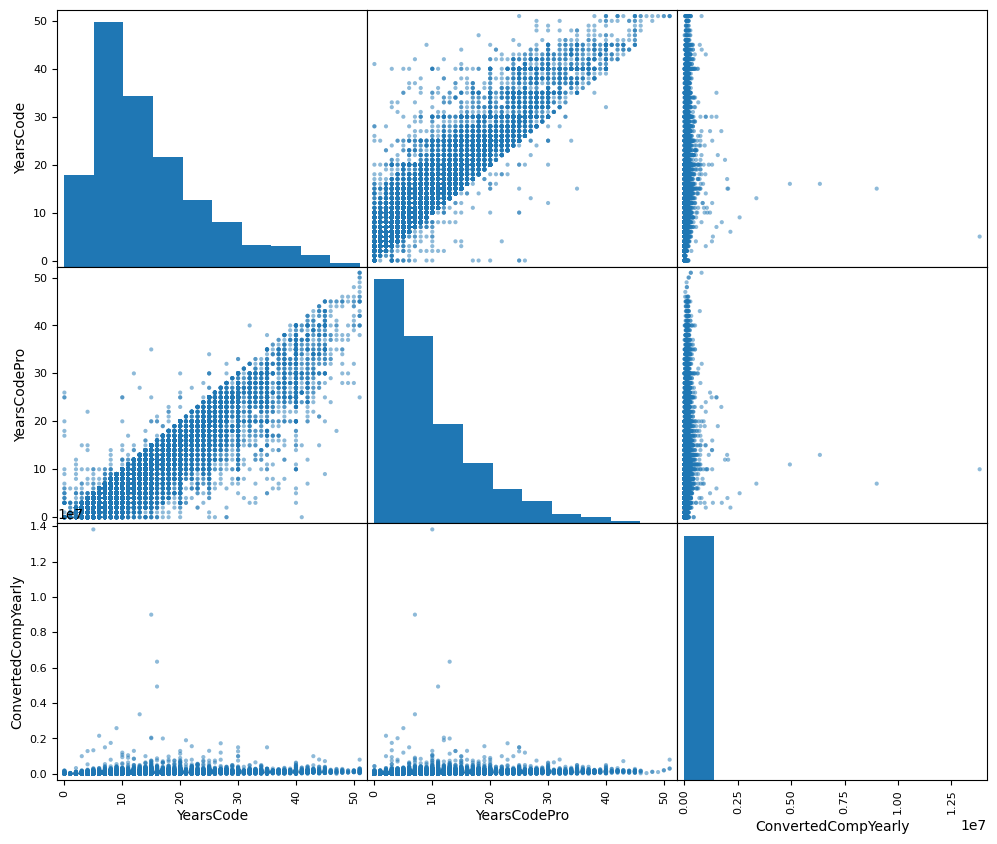

In [ ]:
scatter_matrix(df3[['YearsCode', 'YearsCodePro', 'ConvertedCompYearly']], figsize=(12, 10))

We can see that both `YearsCode` and `YearsCodePro`have a right skewed distribution. <br>

These two variables are clearly correlated &rarr; potentially colinearity <br>

No clear relationship visible between `YearsCode` and `YearsCodePro` and our target. But might at least partially be obscured by the outliers <br>

In [ ]:
# check categorical features for imbalance
cat_features = ['Age', 'RemoteWork', 'CodingActivities', 'EdLevel', 'LearnCode',
       'DevType', 'OrgSize', 'PurchaseInfluence', 'Country', 'ConvertedCompYearly']

for f in cat_features:
    print(f'{f}:')
    
    print(df3[f].value_counts())

Age:
Age
25-34 years old       8799
35-44 years old       4996
18-24 years old       2545
45-54 years old       1688
55-64 years old        605
65 years or older       72
Under 18 years old      17
Prefer not to say        8
Name: count, dtype: int64
RemoteWork:
RemoteWork
Hybrid (some remote, some in-person)    8049
Remote                                  7510
In-person                               3169
Name: count, dtype: int64
CodingActivities:
CodingActivities
Hobby                                                                                                                                                                                                      3705
Hobby;Professional development or self-paced learning from online courses                                                                                                                                  2492
I don’t code outside of work                                                                                      

##### `CodingActivities`

In [ ]:
# For simplicity and essentially interpretability of the model we will only distinguish between those that code outside of work and those who don't
# The number pf possible combination of coding activities outside of work would make the model very hard to interpret
# print(df3['CodingActivities'].unique())

# 0 = dont code outside of work
df3['CodingOutsideOfWork'] = 1
df3.loc[df3['CodingActivities'].str.contains("I don’t code outside of work", na=False), 'CodingOutsideOfWork'] = 0
df3.drop(['CodingActivities'], axis=1, inplace=True)
df3.CodingOutsideOfWork.value_counts()

CodingOutsideOfWork
1    16442
0     2288
Name: count, dtype: int64

##### `LearnCode`

In [ ]:
# For the same reason (interpretability) we will only include one dummy / boolean for each learning type instead of including each possible combination of learning experiences as dummies

df3['PhysicalMedia'] = 0
df3.loc[df3['LearnCode'].str.contains('Books / Physical media', na=False), 'PhysicalMedia'] = 1
print(df3.PhysicalMedia.value_counts())

df3['Bootcamp'] = 0
df3.loc[df3['LearnCode'].str.contains('Coding Bootcamp', na=False), 'Bootcamp'] = 1
print(df3.Bootcamp.value_counts())


df3['Colleague'] = 0
df3.loc[df3['LearnCode'].str.contains('Colleague', na=False), 'Colleague'] = 1
print(df3.Colleague.value_counts())


df3['FriendFamily'] = 0
df3.loc[df3['LearnCode'].str.contains('Friend or family member', na=False), 'FriendFamily'] = 1
print(df3.FriendFamily.value_counts())


df3['Online'] = 0
df3.loc[df3['LearnCode'].str.contains('Online Courses or Certification', na=False), 'Online'] = 1
print(df3.Online.value_counts())


df3['Job'] = 0
df3.loc[df3['LearnCode'].str.contains('On the job training', na=False), 'Job'] = 1
print(df3.Job.value_counts())


df3['OnlineOther'] = 0
df3.loc[df3['LearnCode'].str.contains('Other online resources', na=False), 'OnlineOther'] = 1
print(df3.OnlineOther.value_counts())


df3['School'] = 0
df3.loc[df3['LearnCode'].str.contains('School', na=False), 'School'] = 1
print(df3.School.value_counts())

df3.drop(['LearnCode'], axis=1, inplace=True)



PhysicalMedia
1    9710
0    9020
Name: count, dtype: int64
Bootcamp
0    16823
1     1907
Name: count, dtype: int64
Colleague
0    13554
1     5176
Name: count, dtype: int64
FriendFamily
0    16911
1     1819
Name: count, dtype: int64
Online
1    9567
0    9163
Name: count, dtype: int64
Job
1    9922
0    8808
Name: count, dtype: int64
OnlineOther
1    15432
0     3298
Name: count, dtype: int64
School
1    9511
0    9219
Name: count, dtype: int64


##### `Age`

*Unfortunately* age is available only in categories. we can treat it as ordinal and encode with `OrdinalEncoder`to keep as much information as possible. <br>

*'I prefer no to say'* will be treated as missing value.

In [ ]:
df3.replace(
    {'Prefer not to say': np.nan}, inplace=True
)
df3.Age.unique()

array(['18-24 years old', '35-44 years old', '25-34 years old',
       '45-54 years old', '55-64 years old', '65 years or older',
       'Under 18 years old', nan], dtype=object)

##### `Countries`


In [ ]:
df3['Country'].value_counts()

As a first remedy for the large number of countries with sparse data we will use `frequency encoding`, making the **Assumption**  the frequency of the Country in this data is not due to some sampling bias but rather a reflection of economic factors. 

##### `RemoteWork`

Could be considered ordinal &rarr; `Ordinal Encoding`

In [23]:
df3['RemoteWork'].value_counts()

RemoteWork
Hybrid (some remote, some in-person)    8049
Remote                                  7510
In-person                               3169
Name: count, dtype: int64

##### `EdLevel`

While there is some order of education level this does not hold true for all categories (different types rather than different level), therefore we ordinal encoding is not an option and we have to stick to `one-hot encoding`


In [24]:
df3['EdLevel'].value_counts()

EdLevel
Bachelor’s degree (B.A., B.S., B.Eng., etc.)                                          8745
Master’s degree (M.A., M.S., M.Eng., MBA, etc.)                                       5462
Some college/university study without earning a degree                                2108
Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)     809
Professional degree (JD, MD, Ph.D, Ed.D, etc.)                                         736
Associate degree (A.A., A.S., etc.)                                                    611
Something else                                                                         170
Primary/elementary school                                                               89
Name: count, dtype: int64

In [ ]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split

# --- 1. Custom Frequency Encoder ---
class FrequencyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.freq_maps_ = {}

    def fit(self, X, y=None):
        for col in X.columns:
            freq = X[col].value_counts(normalize=True)
            self.freq_maps_[col] = freq
        return self

    def transform(self, X):
        X_encoded = X.copy()
        for col in X.columns:
            X_encoded[col] = X[col].map(self.freq_maps_[col]).fillna(0)
        return X_encoded

# --- 2. Define feature groups ---
categorical_cols = ['job', 'country', 'other_categorical_features']  # <-- put your actual categorical feature names here
numerical_cols = ['years_of_training']

# --- 3. Preprocessing steps ---
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('freq_encoder', FrequencyEncoder())
])

numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('cat', categorical_pipeline, categorical_cols),
    ('num', numerical_pipeline, numerical_cols)
])

# --- 4. Full Ridge pipeline ---
ridge_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('ridge', RidgeCV(alphas=[0.1, 1.0, 10.0], scoring='neg_mean_squared_error'))
])

# --- 5. Train-test split (example) ---
X = df.drop(columns=['salary'])  # Feature dataframe
y = df['salary']                 # Target variable

# Optional: Light clipping of extreme salary values
salary_cap = np.percentile(y, 99)  # Top 1% capped
y_clipped = np.clip(y, None, salary_cap)

X_train, X_test, y_train, y_test = train_test_split(X, y_clipped, test_size=0.2, random_state=42)

# --- 6. Fit the pipeline ---
ridge_pipeline.fit(X_train, y_train)

# --- 7. Predict on test set ---
y_pred = ridge_pipeline.predict(X_test)

# --- 8. Coefficients inspection (important for interpretability) ---
feature_names = (
    ridge_pipeline.named_steps['preprocessing']
    .transformers_[0][1].named_steps['freq_encoder'].freq_maps_.keys()
) | numerical_cols  # collect all feature names

coefficients = ridge_pipeline.named_steps['ridge'].coef_

# Create a DataFrame of feature importances
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', key=abs, ascending=False)

print(coef_df)


In [ ]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split

# --- 1. Custom Frequency Encoder ---
class FrequencyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.freq_maps_ = {}

    def fit(self, X, y=None):
        for col in X.columns:
            freq = X[col].value_counts(normalize=True)
            self.freq_maps_[col] = freq
        return self

    def transform(self, X):
        X_encoded = X.copy()
        for col in X.columns:
            X_encoded[col] = X[col].map(self.freq_maps_[col]).fillna(0)
        return X_encoded

# --- 2. Define feature groups ---
categorical_cols = ['job', 'country', 'other_categorical_features']  # <-- Update with your actual categorical features
numerical_cols = ['years_of_training']

# --- 3. Preprocessing steps ---
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('freq_encoder', FrequencyEncoder())
])

numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('cat', categorical_pipeline, categorical_cols),
    ('num', numerical_pipeline, numerical_cols)
])

# --- 4. Full Ridge pipeline ---
ridge_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('ridge', RidgeCV(alphas=[0.1, 1.0, 10.0], scoring='neg_mean_squared_error'))
])

# --- 5. Train-test split (example) ---
X = df.drop(columns=['salary'])  # Feature dataframe
y = df['salary']                 # Target variable

# Optional: Light clipping of extreme salary values
salary_cap = np.percentile(y, 99)  # Top 1% capped
y_clipped = np.clip(y, None, salary_cap)

X_train, X_test, y_train, y_test = train_test_split(X, y_clipped, test_size=0.2, random_state=42)

# --- 6. Fit the pipeline ---
ridge_pipeline.fit(X_train, y_train)

# --- 7. Predict on test set ---
y_pred = ridge_pipeline.predict(X_test)

# --- 8. Automatically extract feature names (especially for large datasets) ---
def get_feature_names(preprocessor, columns):
    # Extract names after applying ColumnTransformer
    categorical_names = [f"{col} (freq_encoded)" for col in columns['cat']] 
    numerical_names = columns['num']
    
    return categorical_names + numerical_names

# Get feature names after all transformations
feature_names = get_feature_names(ridge_pipeline.named_steps['preprocessing'], {
    'cat': categorical_cols,
    'num': numerical_cols
})

# --- 9. Coefficients inspection ---
coefficients = ridge_pipeline.named_steps['ridge'].coef_

# Create a DataFrame of feature importances
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', key=abs, ascending=False)

print(coef_df)
